In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec
import os


import yt
from yt import YTArray, YTQuantity
import trident
import numpy as np
import sys
import h5py as h5
import pickle


import seaborn as sns
import palettable
sns.set_style("ticks",{'axes.grid': True, 'grid.linestyle': '--'})

sys.path.append('../analysis')
import spectrum_generating_tools as spg
import spectrum_analysis_tools as spa
import ion_plot_definitions as ipd
import plotting_tools as pt



/Users/irynabutsky/software/yt/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /Users/irynabutsky/.config/yt/ytrc is deprecated in favor of /Users/irynabutsky/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0 . This feature will be removed in v4.1.0
  from yt.config import ytcfg


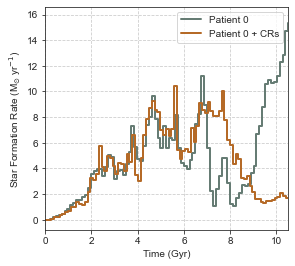

In [2]:
# star formation history plot

#load data
f = h5.File('../../data/simulation_data/sfh_data.h5', 'r')

fig, ax = plt.subplots(figsize = (4.2, 3.8))
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('Star Formation Rate (M$_{\odot}$ yr$^{-1}$)')
ax.set_xlim(0, 10.5)


color_list = palettable.wesanderson.Moonrise2_4.mpl_colors[:2]
for model, label, color in zip(['p0', 'agncr'], ['Patient 0', 'Patient 0 + CRs'], color_list):
     
    x = np.array(f['time_%s'%model])
    y = np.array(f['sfh_%s'%model])
    
    x = np.vstack((x[:-1], x[1:])).reshape((-1), order = 'F')
    y = np.vstack((y, y)).reshape((-1), order = 'F')

    ax.plot(x, y, linewidth = 2, label = label, color = color)

ax.legend()
fig.tight_layout()
plt.savefig('../../plots/sfh.png', dpi = 300)


yt : [INFO     ] 2021-02-20 16:47:01,135 Parameters: current_time              = 3.398869692888919e+17 s
yt : [INFO     ] 2021-02-20 16:47:01,135 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-02-20 16:47:01,136 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2021-02-20 16:47:01,137 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2021-02-20 16:47:01,137 Parameters: cosmological_simulation   = 1.0
yt : [INFO     ] 2021-02-20 16:47:01,138 Parameters: current_redshift          = 0.24979488244391623
yt : [INFO     ] 2021-02-20 16:47:01,139 Parameters: omega_lambda              = 0.6914
yt : [INFO     ] 2021-02-20 16:47:01,139 Parameters: omega_matter              = 0.3086
yt : [INFO     ] 2021-02-20 16:47:01,140 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-02-20 16:47:01,140 Parameters: hubble_constant           = 0.677583430663222
yt : [INFO     ] 2021-02-20 16:47:01,151 Allocating for 1.506e+06 p

/Users/irynabutsky/software/miniconda3/lib/python3.8/site-packages/matplotlib/colors.py:1174: RuntimeWarning: divide by zero encountered in log
  resdat -= np.log(vmin)
/Users/irynabutsky/software/miniconda3/lib/python3.8/site-packages/matplotlib/colors.py:1175: RuntimeWarning: divide by zero encountered in log
  resdat /= (np.log(vmax) - np.log(vmin))
yt : [INFO     ] 2021-02-20 16:47:14,552 Parameters: current_time              = 3.3988696927205075e+17 s
yt : [INFO     ] 2021-02-20 16:47:14,553 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-02-20 16:47:14,553 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2021-02-20 16:47:14,554 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2021-02-20 16:47:14,555 Parameters: cosmological_simulation   = 1.0
yt : [INFO     ] 2021-02-20 16:47:14,555 Parameters: current_redshift          = 0.2497948824964893
yt : [INFO     ] 2021-02-20 16:47:14,555 Parameters: omega_lambda       

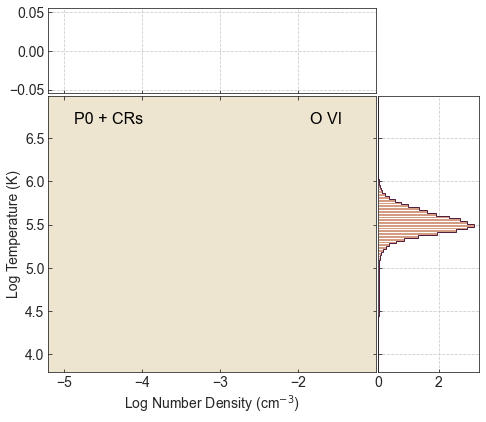

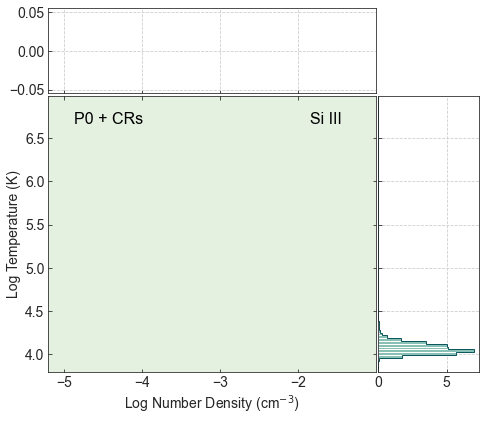

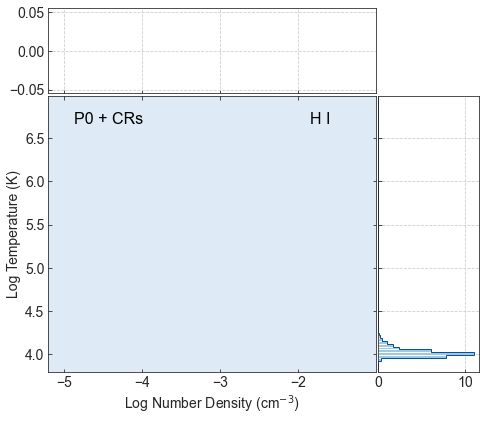

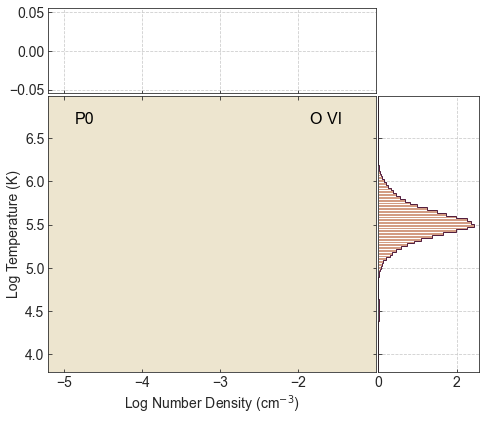

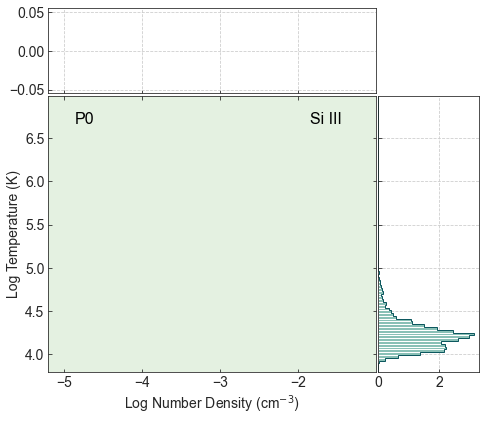

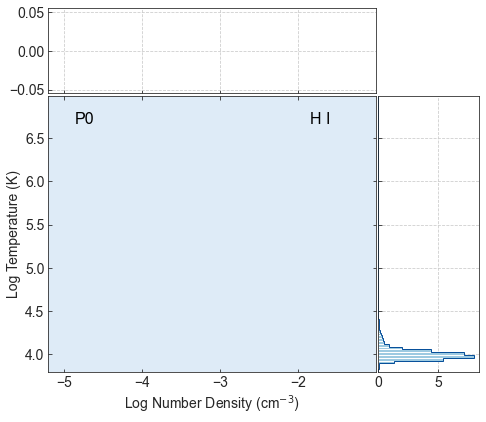

In [2]:

def plot_phase(model, ion = 'O VI', xfield = 'density', yfield = 'temperature'):
    
    ds, gcenter, bv = spg.load_simulation_properties(model)
    trident.add_ion_fields(ds, ions = [ion])  
    
    sp1 = ds.sphere(gcenter, (15, 'kpc'))
    sp2 = ds.sphere(gcenter, (200, 'kpc'))
    sp = sp2 - sp1

    logx_list = np.log10(sp[xfield])
    logy_list = np.log10(sp[yfield])
    
    ion_name = ipd.return_ion_prefix(ion)
    mass_list = sp['%s_mass'%ion_name].in_units('Msun')


    xlims = (-5.2, -1.01)
    ylims = (3.8, 6.99)

    xedges = np.linspace(xlims[0], xlims[1], 100)
    yedges = np.linspace(ylims[0], ylims[1], 100)
    weights = mass_list
    normed = True
    #weights = None

    H, xedges, yedges = np.histogram2d(logx_list, logy_list, bins = (xedges, yedges), weights = weights, normed = normed)
    H = H.T
    X, Y = np.meshgrid(xedges, yedges)


    # definitions for the axes
    left, width = 0.12, 0.65
    bottom, height = 0.11, 0.65
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    fig = plt.figure(figsize=(7, 5.9))
    fs = 14
    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True, labelsize = fs)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False, labelsize = fs)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False, labelsize = fs)

    ax_scatter.set_xlim(xlims[0], xlims[1])
    ax_scatter.set_ylim(ylims[0], ylims[1])
    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())


    ax_scatter.set_xlabel('Log Number Density (cm$^{-3}$)', fontsize = fs)
    ax_scatter.set_ylabel('Log Temperature (K)', fontsize = fs)

   # palette = sns.color_palette("Blues")
#    cmap = cmListedColormap(palette)
    palette = pt.get_palette(ion)
    cmap = ListedColormap(palette)
    background = palette[0]

    ax_scatter.pcolormesh(X, Y, H, norm = LogNorm(), cmap = cmap)
    ax_scatter.set_facecolor(background)


    # add ion and model labels
    xtext = 0.8*(xlims[1] - xlims[0]) + xlims[0]
    ytext = 0.9*(ylims[1] - ylims[0]) + ylims[0]
    ax_scatter.text(xtext, ytext, ion, fontsize = fs+2, color = 'black')
    
    xtext = 0.08*(xlims[1] - xlims[0]) + xlims[0]
    if model == 'P0':
        ax_scatter.text(xtext, ytext, model, fontsize = fs+2, color = 'black')
    else:
        ax_scatter.text(xtext, ytext, 'P0 + CRs', fontsize = fs+2, color = 'black')


    
    ax_histx.hist(logx_list, bins=xedges, weights = weights, density = normed, color = palette[2])
    ax_histx.hist(logx_list, bins=xedges, weights = weights, density = normed, 
                  histtype = 'step', color = palette[-1])
    ax_histy.hist(logy_list, bins=yedges, weights = weights, density = normed, 
                  orientation = 'horizontal', color = palette[2])
    ax_histy.hist(logy_list, bins=yedges, weights = weights, density = normed, 
                  orientation = 'horizontal', histtype = 'step', color = palette[-1])


    ion = ion.replace(" ", "")
    plt.savefig('../../plots/phase_%s_%s.png'%(ion, model), dpi = 300)

    
model_list = ['P0_agncr', 'P0']
ion_list = ['O VI', 'Si III', 'H I']

#ion_list = ['H I']

for model in model_list:
    for ion in ion_list:
        plot_phase(model, ion)

In [2]:
csv_data_file = '../../data/analyzed_spectra/merged_solutions_with_upper_limits.csv'
ion_list, logN_list, logNerr_list, b_list, berr_list, vel_list, \
                vel_err_list, ray_id_list, model_list, impact_list, ovi_label_list, detection_list \
                = pt.load_csv_data(csv_data_file)

mask = (model_list == 'P0agncr')
print(ovi_label_list[mask])

[None None 'narrow' ... None None None]


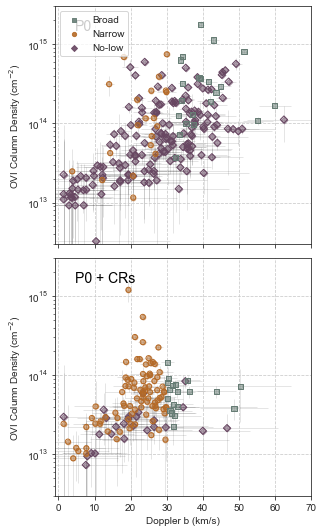

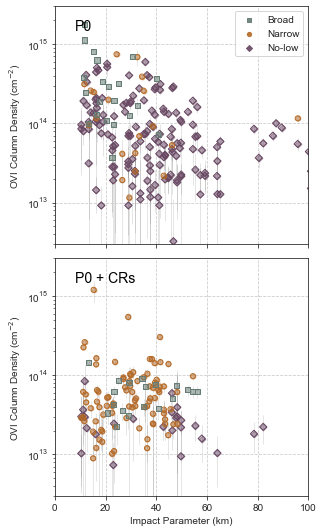

In [8]:
# plotting O VI label plots
def plot_ovi(xfield, impact_min = 0, impact_max = 500, 
             csv_data_file = '../../data/analyzed_spectra/merged_solutions_with_upper_limits.csv'):
    ion_list, logN_list, logNerr_list, b_list, berr_list, vel_list, \
                vel_err_list, ray_id_list, model_list, impact_list, ovi_label_list, detection_list \
                = pt.load_csv_data(csv_data_file)

    if xfield == 'bval':
        x_list = b_list
#        xerr_list = np.log10(b_list + berr_list) - np.log10(b_list - berr_list)
        xerr_list = berr_list
        xlims = (-1, 70) 
        xlabel = 'Doppler b (km/s)'
    elif xfield == 'impact':
        x_list = impact_list
        xerr_list = np.zeros(len(impact_list))
        xlims = (0, 100)
        xlabel = 'Impact Parameter (km)'

    
    fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (4.6, 7.5), sharex = True, sharey = True)
    if xfield == 'bval':
        for a in ax:
            a.plot([0.7, 2.7], [13.5, 15.5], color = 'black', linestyle = 'dashed')
    label_list = ['broad', 'narrow', 'nolow']
    legend_list = ['Broad', 'Narrow', 'No-low']
    marker_list = ['s', 'o', 'D']
    zorder_list = [3, 2, 1]
    color_list = [palettable.wesanderson.Moonrise2_4.mpl_colors[0], palettable.wesanderson.Moonrise2_4.mpl_colors[1], 
                  palettable.wesanderson.Darjeeling4_5.mpl_colors[1]]
    for col, model in enumerate(['P0', 'P0agncr']):
    #    mask = (ion_list == 'OVI') & (model_list == model) & (ray_id_list < 100)
    #    total_ovi = pt.get_total_column(ray_id_list[mask], logN_list[mask])
       # for q in range(len(ion_list[mask])):
        #    print(ray_id_list[mask][q], ion_list[mask][q], logN_list[mask][q], total_ovi[q])

       # ax[col].scatter(x_list[mask], total_ovi, color = 'black', s = 23, zorder = 10)
        for i, label in enumerate(label_list):
            mask = (ion_list == 'OVI') & (model_list == model) & (ovi_label_list == label) \
              & (impact_list > impact_min) & (impact_list < impact_max)
           # ax.scatter(np.log10(b_list[mask]), logN_list[mask], label = legend_list[i])
            x = x_list[mask]
            xerr = xerr_list[mask]
            y = np.power(10, logN_list[mask])
            yerr = np.power(10, logN_list[mask] + logNerr_list[mask]) - np.power(10, logN_list[mask] - logNerr_list[mask])
            ax[col].errorbar(x, y, xerr=xerr, yerr=yerr, linewidth = 0.5, 
                             color = 'black', linestyle = '', alpha = 0.2, zorder = 0)
            ax[col].scatter(x, y, s = 26, marker = marker_list[i], 
                       edgecolor = color_list[i], color = 'None', zorder= zorder_list[i])
            ax[col].scatter(x, y, s = 23, marker = marker_list[i], 
                       color = color_list[i], zorder= zorder_list[i], alpha = 0.5)
            # dummy for legend
            ax[col].scatter(-1, -1, s = 18, marker = marker_list[i], 
                       color = color_list[i], label = legend_list[i], alpha = 0.9)
                
        ax[col].set_ylabel('OVI Column Density (cm$^{-2}$)')
     
    #ylims = (13, 15)
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ylims = (3e12, 3e15)
    ax[0].set_xlim(xlims)#0.7, 2)
    ax[0].set_ylim(ylims)
    ax[1].set_xlabel(xlabel)

    
    xtext = 0.08*(xlims[1] - xlims[0]) + xlims[0]
    ytext = 0.5*(ylims[1] - ylims[0]) + ylims[0]
    ax[0].text(xtext, ytext, 'P0', fontsize = 14, color = 'black')
    ax[1].text(xtext, ytext, 'P0 + CRs', fontsize = 14, color = 'black')
    
    ax[0].legend()
    fig.tight_layout()
    plt.savefig('../../plots/OVI_%s_col.png'%xfield, dpi = 300)

impact_min = 0
impact_max = 300
plot_ovi('bval', impact_min = impact_min, impact_max = impact_max)
plot_ovi('impact', impact_min = impact_min, impact_max = impact_max)

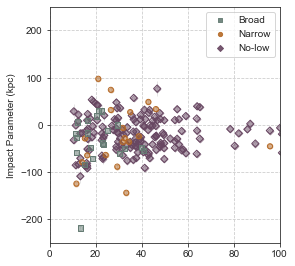

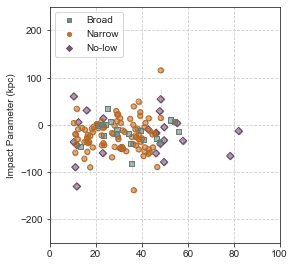

In [6]:
# plotting O VI impact plots
def plot_bval_ovi(model, csv_data_file = '../../data/analyzed_spectra/merged_solutions_with_upper_limits.csv'):
    ion_list, logN_list, logNerr_list, b_list, berr_list, vel_list, vel_err_list, \
        ray_id_list, model_list, impact_list, ovi_label_list, detection_list = pt.load_csv_data(csv_data_file)

    fig, ax = plt.subplots(figsize = (4.2, 3.8))

    label_list = ['broad', 'narrow', 'nolow']
    legend_list = ['Broad', 'Narrow', 'No-low']
    marker_list = ['s', 'o', 'D']
    zorder_list = [3, 2, 1]
    color_list = [palettable.wesanderson.Moonrise2_4.mpl_colors[0], palettable.wesanderson.Moonrise2_4.mpl_colors[1], 
                  palettable.wesanderson.Darjeeling4_5.mpl_colors[1]]
    

    for i, label in enumerate(label_list):
        mask = (ion_list == 'OVI') & (model_list == model) & (ovi_label_list == label)
       # ax.scatter(np.log10(b_list[mask]), logN_list[mask], label = legend_list[i])
        xfield = impact_list[mask]
        yfield = vel_list[mask]
        yerr = vel_err_list[mask]
        ax.errorbar(xfield, yfield, yerr=yerr, linewidth = 0.5, 
                             color = 'black', linestyle = '', alpha = 0.2, zorder = 0)
        ax.scatter(xfield, yfield, s = 26, marker = marker_list[i], 
                   edgecolor = color_list[i], color = 'None', zorder= zorder_list[i])
        ax.scatter(xfield, yfield, s = 23, marker = marker_list[i], 
                   color = color_list[i], zorder= zorder_list[i], alpha = 0.5)
        # dummy for legend
        ax.scatter(-1, -1, s = 18, marker = marker_list[i], 
                   color = color_list[i], label = legend_list[i], alpha = 0.9)
    ax.set_xlim(0, 100)
    ax.set_ylim(-250, 250)   
    ax.set_ylabel('Velocity Offset (km/s)')
    ax.set_ylabel('Impact Parameter (kpc)')
    ax.legend()
    fig.tight_layout()
    plt.savefig('../../plots/OVI_vel_impact_%s.png'%model, dpi = 300)

for model in ['P0', 'P0agncr']:
    plot_bval_ovi(model)

<ipython-input-22-e0477fdb58da>:101: RuntimeWarning: divide by zero encountered in log10
  log_total_si_col = np.log10(np.sum(np.power(10, logN_list[si_mask])))
<ipython-input-22-e0477fdb58da>:102: RuntimeWarning: divide by zero encountered in log10
  log_total_ovi_col = np.log10(np.sum(np.power(10, logN_list[ovi_mask])))


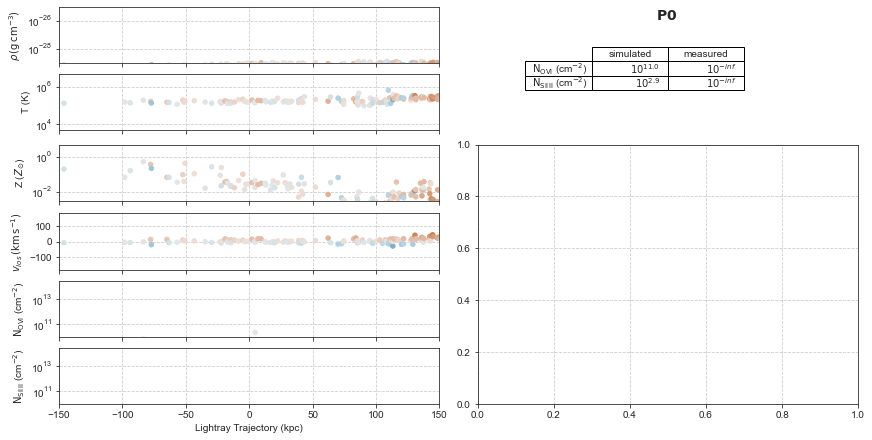

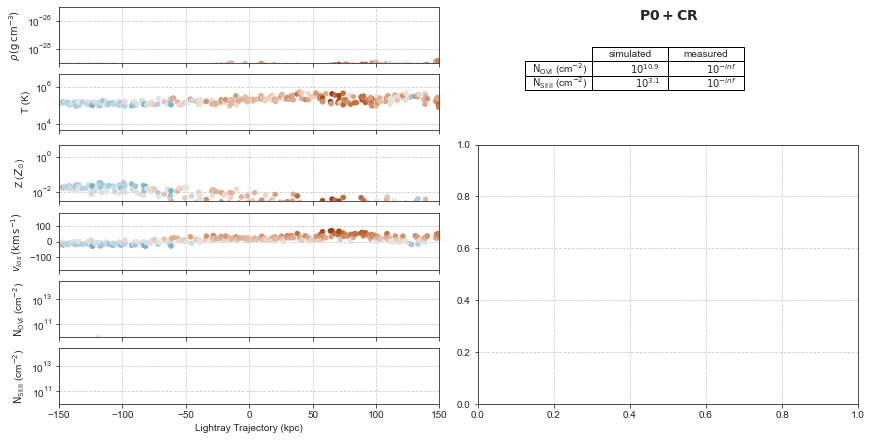

In [22]:
def convert_to_vel(wl, w0):
    return (wl-w0) / w0 * 2.9979e5

def los_vel(vx, vy, vz, bv = [0, 0, 0], normal = [0, 0, 1]):
    vx = np.array(vx - bv[0])
    vy = np.array(vy - bv[1])
    vz = np.array(vz - bv[2])

    normal_mag = np.linalg.norm(normal)
    normal = np.divide(normal, normal_mag)

    v_dot_norm = vx*normal[0] + vy*normal[1] + vz*normal[2]
    return v_dot_norm

def plot_ion_fit(model, ray_id, ax = None, ion_list = ['Si III', 'O VI'], 
                 data_loc = '../../data/unanalyzed_spectra'):
   # color_list = ['purple', 'cornflowerblue', 'orange']

    spec = 'COS-FUV_%s_z0.25_%04d'%(model, ray_id)
    if model == 'P0_agncr':
        model = 'P0agncr'

    fit_file  = '../../data/analyzed_spectra/synth_%s%04d_eval.pickle'%(model, ray_id)
    if not os.path.isfile(fit_file):
        return
    fit_data = pickle.load( open(fit_file, 'rb'))


    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.8, 2.2))

    for ion in ion_list:
        vv, flux, vvfit, fluxfit,  wl, wlfit, w0 = spa.load_velocity_data(ion, spec, 
                                            unanalyzed = True, work_dir = data_loc)
        new_v = np.ravel(np.column_stack((vv, vv)))
        new_f = np.ravel(np.column_stack((flux, flux)))
        ax.plot(new_v[1:], new_f[:-1], color = 'black',linewidth = 0.5, alpha = 0.3, zorder = 0)
    
        color = pt.get_palette(ion)[4]
        for fit in fit_data:
            wl = fit['wavelength']
            fluxfit = fit['full']
            vvfit = convert_to_vel(wl, w0)

            ax.plot(vvfit, fluxfit, color = 'black', linewidth = 5, alpha = 0.8)
            ax.plot(vvfit, fluxfit, color = color, linewidth = 2, alpha = 1)

        # just for the label
        ax.plot(vvfit, -100*fluxfit, color = color, label = ion)
            
    ax.set_xlim(-295, 295)
    
    ax.set_ylim(-0.05, 1.3)
    ax.set_xlabel('Relative Velocity (km/s)')
    ax.set_ylabel('Normalized Flux')
    ax.legend()


    
def load_sightline_scatter_data(sim, ray_id, output = 3195):
    fn = '../../data/unanalyzed_spectra/ray_%s_%i_%i.h5'%(sim, output, ray_id)    
    plot_data = h5.File(fn, 'r')['grid']

    l = YTArray(plot_data['l'], 'cm')
    l = np.array(l.in_units('kpc'))

    temperature = np.array(plot_data['temperature'])
    density     = np.array(plot_data['density'])
    metallicity = np.array(plot_data['metallicity'])*77.22007722007721  # converting from code units to zsun
    vx          = np.array(plot_data['relative_velocity_x']) / 1e5 # converting to km/s
    vy          = np.array(plot_data['relative_velocity_y']) / 1e5 # converting to km/s
    vz          = np.array(plot_data['relative_velocity_z']) / 1e5 # converting to km/s

    vlos        = np.array(plot_data['velocity_los']) / 1e5
    dl = np.array(plot_data['dl'])
    
    # O VI and H I column densities
    oden = np.array(plot_data['O_p5_number_density'])
    ocol  = dl * np.array(oden)
    sicol = dl* np.array(plot_data['Si_p2_number_density'])
    hcol  = dl * np.array(plot_data['H_p0_number_density'])
    
    return l, temperature, density, metallicity, vlos, ocol, sicol

def load_sightline_data(sim, ray_id, csv_data_file = '../../data/analyzed_spectra/merged_solutions.csv'):
    if sim == 'P0_agncr':
        sim = 'P0agncr'
        
    ion_list, logN_list, logNerr_list, b_list, berr_list, vel_list, \
                vel_err_list, ray_id_list, model_list, impact_list, ovi_label_list = pt.load_csv_data(csv_data_file)
    mask = (model_list == sim) & (ray_id_list == ray_id)
    
    impact_parameter = impact_list[mask]
    if len(impact_parameter) > 0:
        impact_parameter = impact_parameter[0]
    
    ovi_label = 'none'
    si_mask = mask & (ion_list == 'SiIII')
    ovi_mask = mask & (ion_list == 'OVI')

    log_total_si_col = np.log10(np.sum(np.power(10, logN_list[si_mask])))
    log_total_ovi_col = np.log10(np.sum(np.power(10, logN_list[ovi_mask])))

    return impact_parameter, log_total_si_col, log_total_ovi_col
    
    
def plot_sightline_data(sim, ray_id, output = 3195):
    l, temperature, density, metallicity, vlos, ocol, sicol = \
        load_sightline_scatter_data(sim, ray_id, output = output)
    l -= 250

    field_list = [density, temperature, metallicity, vlos, ocol, sicol]#, hcol]
    ylim_list = [(1e-29, 1e-25), (5e3, 5e6), (3e-3, 5), (-185, 185), (1e10, 3e14), (1e10, 3e14)]  
    ytick_list = [(1e-28, 1e-26), (1e4, 1e6), (1e-2, 1), (-100, 0, 100), (1e11, 1e13), (1e11, 1e13)]

    ylabel_list = ['$\\rho\, ({\\rm g}\, {\\rm cm}^{-3})$', 'T (K)', 'Z ($Z_{\odot}$)', 
                   '$v_{los}\, ({\\rm km}\, {\\rm s}^{-1})$',
                   '${\\rm N}_{\\rm OVI}$ (cm$^{-2}$)', '${\\rm N}_{\\rm SiIII}$ (cm$^{-2}$)']
    ion_list = ['OVI', 'SiIII']
    cmap = pt.get_cmap('velocity')
    nrows = 6
   # fig, ax = plt.subplots(nrows = nrows, ncols = 1 , figsize = (6, len(field_list)),
   #                            sharex=True, sharey=False)
    fig = plt.figure(figsize = (12, 6), constrained_layout=True)

    gs = GridSpec(6, 6, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0:3])
    ax2 = fig.add_subplot(gs[1, 0:3])
    ax3 = fig.add_subplot(gs[2, 0:3])
    ax4 = fig.add_subplot(gs[3, 0:3])
    ax5 = fig.add_subplot(gs[4, 0:3])
    ax6 = fig.add_subplot(gs[5, 0:3])
    
    ax7 = fig.add_subplot(gs[2:, 3:])
    
    plot_ion_fit(sim, ray_id, ax = ax7)
    ax = [ax1, ax2, ax3, ax4, ax5, ax6]
    
    for i in range(len(field_list)):
        row = i
        vmin = -100
        vmax = 100
        
        data = field_list[i]
        ax[row].scatter(l, data, c = vlos, s = 20, cmap = cmap, vmin = vmin, vmax = vmax)
        
        ax[row].set_xlim(-150, 150)        
        if i != 3: # los velocity
            ax[row].set_yscale('log')
        if i < len(field_list)-1:
            ax[i].set_xticklabels([])
        ylims = ylim_list[row]
        ax[row].set_ylim(ylims[0], ylims[1])
        ax[row].set_ylabel(ylabel_list[row])
        ax[row].set_yticks(ytick_list[i])
    
    ax[-1].set_xlabel('Lightray Trajectory (kpc)')
    #fig.tight_layout()
    #fig.subplots_adjust(hspace = 0.1)

    # plot text description
    ax8 = fig.add_subplot(gs[:2, 3:])
    ax8.set_xticks([])
    ax8.set_yticks([])
    ax8.axis('off')
    
    impact, sicol, ocol = load_sightline_data(sim, ray_id)
    if sim == 'P0_agncr':
        ax8.text(0.425, 0.9, '$\\rm \\bf P0+CR$', fontsize = 14)
    else:
        ax8.text(0.47, 0.9, '$\\rm \\bf P0$', fontsize = 14)
        
    sim_ovi = np.log10(np.sum(field_list[4]))
    sim_si = np.log10(np.sum(field_list[5]))
    
    data = [[sim_ovi, ocol], [sim_si, sicol]]
    columns = ('simulated', 'measured')
    rows = ['${\\rm N}_{\\rm OVI}$ (cm$^{-2}$)', '${\\rm N}_{\\rm SiIII}$ (cm$^{-2}$)']

    cell_text = [['$10^{%.1f}$'%sim_ovi, '$10^{%.1f}$'%ocol], ['$10^{%.1f}$'%sim_si, '$10^{%.1f}$'%sicol]]
    
    ax8.table(cellText = cell_text, rowLabels = rows, colLabels = columns, loc = 'center', colWidths = [0.2, 0.2] )

    plt.savefig('../../plots/sightline/sightline_data_%s_%i.png'%(sim, ray_id), dpi = 300)
for model in ['P0', 'P0_agncr']:
    for ray in range(100, 101):
        plot_sightline_data(model, ray)
#model = 'P0_agncr'
#ray = 8
#plot_sightline_data(model, ray)

In [ ]:

def los_vel(vx, vy, vz, bv = [0, 0, 0], normal = [0, 0, 1]):
    vx = np.array(vx - bv[0])
    vy = np.array(vy - bv[1])
    vz = np.array(vz - bv[2])
    #vel = np.column_stack((vx, vy, vz))

    normal_mag = np.linalg.norm(normal)
    normal = np.divide(normal, normal_mag)

    v_dot_norm = vx*normal[0] + vy*normal[1] + vz*normal[2]
   # print(v_dot_rhat.shape)
    return v_dot_norm

def plot_ray_image(model, ray_id):

    f = h5.File('../../data/ray_files/ray_image_data_%s_3195_%i.h5'%(model, ray_id), 'r')

    field_list = ['density', 'temperature', 'metallicity', 'velocity_los',  'O_p5_mass', 'Si_p2_mass', 'H_p0_mass']
    ylim_list = [(-29, -25.5), (.7, 6.1), (-3.5, -.3), (-185, 185), (12, 15), (12, 15), (12, 21)]
 #   ytick_list = [(-28, -26), (4, 6)]
    zlim_list  = [(3e-29, 1e-25), (8e4, 1e6), (3e-3, 1), (-200, 200), (1e13, 3e15),
                  (1e13, 3e16), (1e13, 1e21)]
    ylabel_list = ['Density (g cm$^{-3}$)', 'Temperature (K)', 'Metallicity ($Z_{\odot}$)', 
                        'LOS Velocity (km/s)', 'O VI Mass', 'Si III Mass', 'H I Mass']

    l, temperature, density, metallicity, vlos, ocol, sicol = \
        load_sightline_scatter_data(model, ray_id)
    
    scatter_field_list = [ density, temperature, metallicity, vlos, ocol, sicol, hcol]
    
    fig, ax = plt.subplots(nrows = 7, ncols =1, figsize = (17, 8))
    for i, field in enumerate(field_list):
        if field == 'velocity_los':
            vx = np.array(f['velocity_x']) / 1e5
            vy = np.array(f['velocity_y']) / 1e5
            vz = np.array(f['velocity_z']) / 1e5
            ray_direction = spg.calculate_ray_direction(ray_id, ray_data_file = '../../data/random_sightlines.dat')
            image = los_vel(vx, vy, vz, bv = spg.load_bulk_velocity(model), normal = ray_direction)
            norm = None
        else:
            image = np.array(f[field])
            norm = LogNorm()
        if field == 'metallicity':
            image *= 77.22007722007721  # converting from code units to zsun

        im = ax[i].pcolormesh(image.T, norm = norm, cmap = pt.get_cmap(field))
        ax[i].axhline(40, linewidth = 1, color = 'white', linestyle = 'dashed')
        cbax = inset_axes(ax[i], width = "30%", height = "13%", loc = 6)
        cbar = fig.colorbar(im, cax=cbax, orientation = 'horizontal')
        cbar.ax.set_title(ylabel_list[i], color = 'black')
        
        
        # scatter data        
        data_xrange = 500.
        plot_xrange = 1200.
        
        data_yrange = np.abs(ylim_list[i][1] - ylim_list[i][0])
        plot_yrange = 80.
        
        # convert data to image units
        data = scatter_field_list[i]
        mask = (data > ylim_list[i][0]) & (data < ylim_list[i][1])
        x = l[mask] * plot_xrange / data_xrange
        y = (data[mask] - ylim_list[i][0]) * plot_yrange / data_yrange

        ax[i].scatter(x, y, color = 'white')
        
        if i < len(field_list) -1:
            ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_xlim(0, 1200)
        ax[i].set_ylim(0, 80)

    ax[-1].set_xlabel('Lightray Trajectory')
    
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    #plt.savefig('../../plots/ray_P0_3195_%i.png'%ray_id, dpi = 300)
    plt.savefig('test.png', dpi= 300)
    f.close()
    
plot_ray_image('P0', 5)

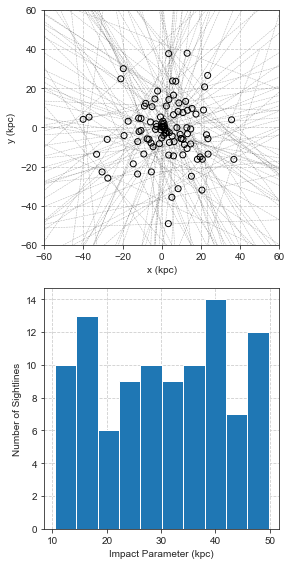

In [38]:
ray_data_file ='../../data/random_sightlines.dat' #centered at zero, not gcenter
impact_list, xi, yi, zi, xf, yf, zf =\
        np.loadtxt(ray_data_file, skiprows = 1, unpack = True, usecols = (1, 2, 3, 4, 5, 6, 7))

fig, ax = plt.subplots(ncols = 1, nrows = 2, figsize = (4, 8))
x = np.linspace(-150, 150, 800)
y = np.linspace(-150, 150, 800)

#cmap = palettable.cmocean.sequential.Gray_20_r.mpl_colormap
#ax.pcolormesh(x, y, data, norm = LogNorm(), cmap = cmap)
ax[0].set_aspect(1)
radius = 60
ax[0].set_xlim(-radius, radius)
ax[0].set_ylim(-radius, radius)
counter = 60
for ray_id in range(100):
    # x projection
#    mask = (ray_id_list == ray_id) & (ion_list == 'OVI') & (logN_list > 13.5) & (model_list == model)
#    if len(ovi_label_list[mask]) > 0:
    ray_start = np.array([xi[ray_id], yi[ray_id]])
    ray_end = np.array([xf[ray_id], yf[ray_id]])
    ray_center = ray_start + 0.5*(ray_end - ray_start)
    ax[0].scatter(ray_center[0], ray_center[1], color = 'None', edgecolor = 'black')
    ax[0].plot([xi[ray_id], xf[ray_id]], [yi[ray_id], yf[ray_id]], linewidth = 0.5, 
            linestyle = 'dashed', color = 'black', alpha = 0.3)
ax[0].set_xlabel('x (kpc)')
ax[0].set_ylabel('y (kpc)')

ax[1].hist(impact_list[:100])
ax[1].set_xlabel('Impact Parameter (kpc)')
ax[1].set_ylabel('Number of Sightlines')

fig.tight_layout()
plt.savefig('../../plots/sightline_description.png', dpi = 300)


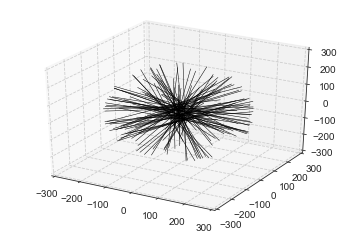

In [18]:
fig = plt.figure()
ax = plt.axes(projection='3d')
radius = 300
ax.set_xlim(-radius, radius)
ax.set_ylim(-radius, radius)
ax.set_zlim(-radius, radius)

for ray_id in range(100):

    xline = [xi[ray_id], xf[ray_id]]
    yline = [yi[ray_id], yf[ray_id]]
    zline = [zi[ray_id], zf[ray_id]]
    #impact = np.linalg.norm(ray_center)
    #print(impact_list[ray_id], impact)
    ax.plot(xline, yline, zline, color = 'black', linewidth = 0.5)
  #  ax.plot([yi[ray_id], yf[ray_id]], [zi[ray_id], zf[ray_id]], linewidth = 0.5, 
  #          linestyle = 'dashed', color = 'black', alpha = 0.6)


In [ ]:
# next steps: calculate where along the sightline the OVI is > tahn some percent of it's final column density. 
#consider this where the absorption happened
# then, place scatter point at that point on the line along projected sightline
# not confirm orientation between sightlines on plot and in ray riles

yt : [INFO     ] 2021-03-02 09:42:29,432 Parameters: current_time              = 3.3988696927205075e+17 s
yt : [INFO     ] 2021-03-02 09:42:29,433 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-03-02 09:42:29,434 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2021-03-02 09:42:29,435 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2021-03-02 09:42:29,435 Parameters: cosmological_simulation   = 1.0
yt : [INFO     ] 2021-03-02 09:42:29,436 Parameters: current_redshift          = 0.2497948824964893
yt : [INFO     ] 2021-03-02 09:42:29,437 Parameters: omega_lambda              = 0.6914
yt : [INFO     ] 2021-03-02 09:42:29,437 Parameters: omega_matter              = 0.3086
yt : [INFO     ] 2021-03-02 09:42:29,438 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-03-02 09:42:29,438 Parameters: hubble_constant           = 0.677583430663222
yt : [INFO     ] 2021-03-02 09:42:29,466 Allocating for 3.151e+07 p

0.5866532397363036
0.5866532397363036


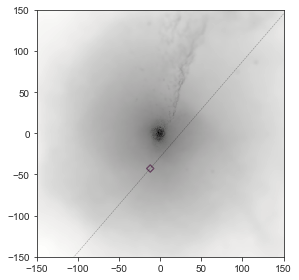

In [56]:
def find_ovi_loc_along_ray(sim, ray_id):
    l, temperature, density, metallicity, vlos, ocol, sicol = \
        load_sightline_scatter_data(model, ray_id)
    
    ocol_sum = np.cumsum(ocol)
    total_ocol = ocol_sum[-1]
    
    ovi_loc_along_ray = 0
    for i in range(len(ocol)):
        if ocol_sum[i] > 0.9*total_ocol:
            ovi_loc_along_ray = l[i] / 500 #fraction of 500 kpc
            break
    print(ovi_loc_along_ray)
    return ovi_loc_along_ray



model = 'P0'
ds, gcenter, bv = spg.load_simulation_properties(model)
#if model == 'P0_agncr':
#    model = 'P0agncr'
#ray_data_file = '../../data/unanalyzed_spectra/%s_z0.25_ray_data.dat'%model
ray_data_file ='../../data/random_sightlines.dat' #centered at zero, not gcenter



csv_data_file = '../../data/analyzed_spectra/merged_solutions.csv'
ion_list, logN_list, logNerr_list, b_list, berr_list, vel_list, \
        vel_err_list, ray_id_list, model_list, impact_list, ovi_label_list = pt.load_csv_data(csv_data_file)


p = yt.ProjectionPlot(ds, 'y', ('gas', 'density'), center = gcenter, width = (300, 'kpc'))
frb = p.data_source.to_frb((300, 'kpc'), 800)

data = frb[('gas', 'density')]



fig, ax = plt.subplots()
x = np.linspace(-150, 150, 800)
y = np.linspace(-150, 150, 800)

cmap = palettable.cmocean.sequential.Gray_20_r.mpl_colormap
ax.pcolormesh(x, y, data, norm = LogNorm(), cmap = cmap)
ax.set_aspect(1)
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)
counter = 0
for ray_id in range(98, 99):
    # x projection
    if model == 'P0_agncr':
        model_name = 'P0agncr'
    else:
        model_name = model
    mask = (ray_id_list == ray_id) & (ion_list == 'OVI') & (logN_list > 13.5) & (model_list == model_name)
    if len(ovi_label_list[mask]) > 0:
        ray_start = np.array([xi[ray_id], zi[ray_id]])
        ray_end = np.array([xf[ray_id], zf[ray_id]])
        
        for ovi_label in ovi_label_list[mask]:
            ray_center = ray_start + 0.5*(ray_end - ray_start)
            if ovi_label == None:
                continue
            if ovi_label == 'broad':
                color = palettable.wesanderson.Moonrise2_4.mpl_colors[0]
                marker = 's'
                zorder = 3
            elif ovi_label == 'narrow':
                color = palettable.wesanderson.Moonrise2_4.mpl_colors[1]
                marker = 'o'
                zorder = 2
            elif ovi_label == 'nolow':
                color = palettable.wesanderson.Darjeeling4_5.mpl_colors[1]
                marker = 'D'
                zorder = 1
                
            ax.plot([xi[ray_id], xf[ray_id]], [zi[ray_id], zf[ray_id]], linewidth = 0.5, linestyle = 'dashed',
                color = 'black', alpha = 0.2)
            
            ovi_absorption = ray_start + find_ovi_loc_along_ray(model, ray_id) * (ray_end - ray_start)
            
            ax.scatter(ovi_absorption[0], ovi_absorption[1], s = 26, marker = marker, 
                       edgecolor = color, color = 'None', zorder= zorder)
            #ax.scatter(ray_center[0], ray_center[1], s = 23, marker = marker, 
            #           color = color, zorder= zorder, alpha = 0.5)        
            counter +=1
fig.tight_layout()
plt.savefig('../../plots/OVI_mapped_%s.png'%model, dpi =300)

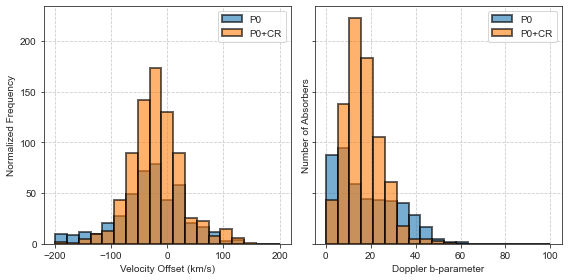

In [47]:
csv_data_file = '../../data/analyzed_spectra/merged_solutions.csv'
ion_list, logN_list, logNerr_list, b_list, berr_list, vel_list, \
        vel_err_list, ray_id_list, model_list, impact_list, ovi_label_list = pt.load_csv_data(csv_data_file)


fig, ax = plt.subplots(nrows =1, ncols =2, figsize =(8, 4), sharey = True, sharex= False)
lw = 2
ht = 'stepfilled'
ht = 'bar'
dens = False
nbin = np.linspace(-200, 200, 20)
ec = 'black'
alpha = 0.6

po_mask = (model_list == 'P0') & (ion_list == 'OVI')

ax[0].hist(vel_list[model_list == 'P0'],  bins = nbin, linewidth = lw, histtype = ht, density = dens, label= 'P0', edgecolor = ec, alpha = alpha)
ax[0].hist(vel_list[model_list == 'P0agncr'], bins = nbin, linewidth = lw, histtype = ht, density = dens, label= 'P0+CR', edgecolor = ec, alpha = alpha)
ax[0].legend()
ax[0].set_ylabel('Normalized Frequency')
ax[0].set_xlabel('Velocity Offset (km/s)')

nbin = np.linspace(0, 100, 20)
ax[1].hist(b_list[model_list == 'P0'],  bins = nbin, linewidth = lw, histtype = ht, density = dens, label= 'P0', edgecolor = ec, alpha = alpha)
ax[1].hist(b_list[model_list == 'P0agncr'], bins = nbin, linewidth = lw, histtype = ht, density = dens, label= 'P0+CR', edgecolor = ec, alpha = alpha)
ax[1].legend()
ax[1].set_ylabel('Number of Absorbers')
ax[1].set_xlabel('Doppler b-parameter')

fig.tight_layout()
plt.savefig('../../plots/vel_bval_histogram.png', dpi = 300)

29.7336080036 7.9989812312
23.393273466500002 15.8193447404


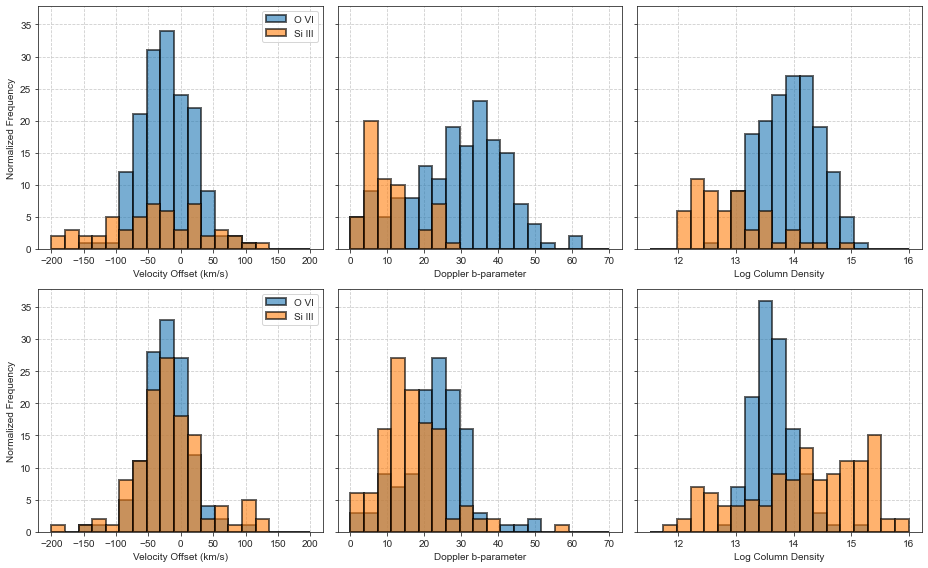

In [11]:
csv_data_file = '../../data/analyzed_spectra/merged_solutions_with_upper_limits.csv'
ion_list, logN_list, logNerr_list, b_list, berr_list, vel_list, \
        vel_err_list, ray_id_list, model_list, impact_list, ovi_label_list, detection_list = pt.load_csv_data(csv_data_file)


fig, ax = plt.subplots(nrows =2, ncols =3, figsize =(13, 8), sharey = True, sharex= False)
lw = 2
ht = 'stepfilled'
ht = 'bar'
dens = False
ec = 'black'
alpha = 0.6

impact_min = 0
impact_max = 50
impact_mask = (impact_list > impact_min) & (impact_list < impact_max) & (detection_list == 'detection')
for i, model in enumerate(['P0', 'P0agncr']):
    si_mask = impact_mask & (model_list == model) & (ion_list == 'SiIII')
    ovi_mask = impact_mask & (model_list == model) & (ion_list == 'OVI')

    print(np.median(b_list[ovi_mask]), np.median(b_list[si_mask]))

    nbin = np.linspace(-200, 200, 20)
    ax[i][0].hist(vel_list[ovi_mask],  bins = nbin, linewidth = lw, histtype = ht, density = dens, label= 'O VI', edgecolor = ec, alpha = alpha)
    ax[i][0].hist(vel_list[si_mask], bins = nbin, linewidth = lw, histtype = ht, density = dens, label= 'Si III', edgecolor = ec, alpha = alpha)
    ax[i][0].legend()
    ax[i][0].set_ylabel('Normalized Frequency')
    ax[i][0].set_xlabel('Velocity Offset (km/s)')

    nbin = np.linspace(0, 70, 20)
    ax[i][1].hist(b_list[ovi_mask],  bins = nbin, linewidth = lw, histtype = ht, density = dens, label= 'O VI', edgecolor = ec, alpha = alpha)
    ax[i][1].hist(b_list[si_mask], bins = nbin, linewidth = lw, histtype = ht, density = dens, label= 'Si III', edgecolor = ec, alpha = alpha)
    ax[i][1].set_xlabel('Doppler b-parameter')


    nbin = np.linspace(11.5, 16, 20)
    ax[i][2].hist(logN_list[ovi_mask],  bins = nbin, linewidth = lw, histtype = ht, density = dens, label= 'O VI', edgecolor = ec, alpha = alpha)
    ax[i][2].hist(logN_list[si_mask], bins = nbin, linewidth = lw, histtype = ht, density = dens, label= 'Si III', edgecolor = ec, alpha = alpha)
    ax[i][2].set_xlabel('Log Column Density')
    
fig.tight_layout()
plt.savefig('../../plots/vel_bval_histogram_%s.png'%model, dpi = 300)

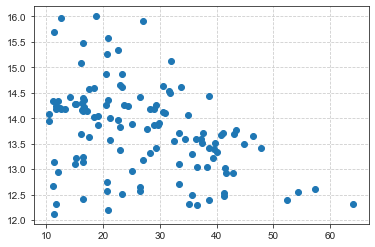

In [9]:
csv_data_file = '../../data/analyzed_spectra/merged_solutions.csv'
ion_list, logN_list, logNerr_list, b_list, berr_list, vel_list, \
        vel_err_list, ray_id_list, model_list, impact_list, ovi_label_list = pt.load_csv_data(csv_data_file)

model = 'P0agncr'
ion = 'SiIV'

mask = (model_list == model) & (ion_list == ion)

plt.scatter(impact_list[mask], logN_list[mask])

0 ['OVI'] ['SiIV']
1 ['OVI'] ['SiIV' 'SiIV']
2 ['OVI'] ['SiIV' 'SiIV']
3 ['OVI' 'OVI'] ['SiIV']
4 ['OVI'] ['SiIV' 'SiIV']
5 ['OVI' 'OVI'] ['SiIV']
6 ['OVI' 'OVI'] ['SiIV' 'SiIV']
7 ['OVI'] ['SiIV']
8 ['OVI'] ['SiIV']
9 ['OVI'] []


ValueError: min() arg is an empty sequence

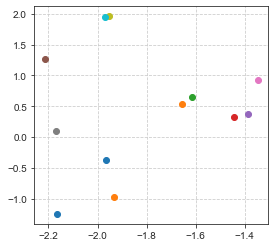

In [13]:
model == 'P0'
N_lim = 12
Si_lim = 12

fig, ax = plt.subplots(figsize =(4.2, 4))
for i in range(100):
    ovi_mask = (ray_id_list == i) & (model_list == model) & (ion_list == 'OVI')
    si_mask = (ray_id_list == i) & (model_list == model) & (ion_list == 'SiIV')
    #print(i, model, ion_list[ovi_mask], ion_list[siIII_mask])                           
    if len(ion_list[ovi_mask]) == 0:
        continue
    o_vel_list = vel_list[ovi_mask]
    si_vel_list = vel_list[si_mask]
    print(i, ion_list[ovi_mask], ion_list[si_mask])
    for j, o_vel in enumerate(o_vel_list):
        ocol = logN_list[ovi_mask][j]
        log_n_o = N_lim - ocol
        dvel_list = o_vel - si_vel_list
        ovi_label_mask = ovi_mask & (vel_list == o_vel)

        if min(np.abs(dvel_list)) > 50:
            log_si_o = Si_lim - ocol
        else:
            for k, si_vel in enumerate(si_vel_list):
                if si_vel - o_vel < 50:
                    log_si_o = logN_list[si_mask][k] - ocol
        ax.scatter(log_n_o, log_si_o)

In [ ]:
# idea add simulation data to plots in figure 6
# or: make 2d histobram of log O VI vs gas velocity magnitude

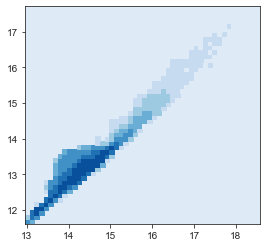

In [46]:
model = 'P0'
frb = h5.File('../../data/simulation_data/multipanel_data_%s_003195'%(model), 'r')

oVI  = np.array(frb['O_p5_number_density'])
siIV = np.array(frb['Si_p3_number_density'])
nV   = np.array(frb['N_p4_number_density'])


si_lim = 1e12
nV_lim = 1e12

#siIV[siIV < si_lim] = si_lim
#nV[nV < nV_lim] = nV_lim

xfield = np.log10(nV / oVI).ravel()
yfield = np.log10(siIV / oVI).ravel()


yfield = np.log10(nV).ravel()
xfield = np.log10(oVI).ravel()

H, xedges, yedges = np.histogram2d(xfield, yfield, bins = 50, weights = None, normed = True)
H = H.T
X, Y = np.meshgrid(xedges, yedges)


palette = pt.get_palette('H I')
cmap = ListedColormap(palette)
#cmap = pt.get_cmap('H_p0_number_density')
background = palette[0]

fig, ax = plt.subplots(figsize = (4.2, 4))

ax.pcolormesh(X, Y, H, norm = LogNorm(), cmap = cmap)
#ax.set_aspect('equal')
ax.set_facecolor(background)

75180
0.0 12.189654637278252
75180
0.0 3.635331933146632


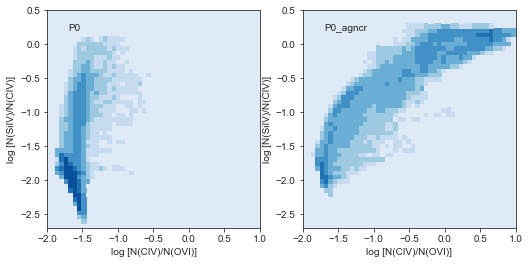

In [26]:
model = 'P0_agncr'
def plot_ion_ratios(ax, model, plot_type = 1):
    frb = h5.File('../../data/simulation_data/multipanel_data_%s_003195'%(model), 'r')

    oVI  = np.array(frb['O_p5_number_density']).ravel()
    siIV = np.array(frb['Si_p3_number_density']).ravel()
    nV   = np.array(frb['N_p4_number_density']).ravel()
    cIV = np.array(frb['C_p3_number_density']).ravel()


    si_lim = 1e12
    nV_lim = 1e12
    ovi_lim = 1e13


    # make impact parameter array:
    width = yt.YTQuantity(300, 'kpc')
    res = 800
    px, py = np.mgrid[-width/2:width/2:res*1j, -width/2:width/2:res*1j]
    radius = ((px**2.0 + py**2.0)**0.5).ravel()

    #siIV[siIV < si_lim] = si_lim
    #nV[nV < nV_lim] = nV_lim
    #oVI[oVI < ovi_lim] = ovi_lim
    if plot_type == 1:
        xfield = np.log10(cIV / oVI)
        yfield = np.log10(siIV / cIV)
        mask = (radius > 15) & (radius < 60) & (cIV > 11.5) & (siIV > 11.5) & (oVI > 12)
        xlabel = 'log [N(CIV)/N(OVI)]'
        ylabel = 'log [N(SiIV)/N(CIV)]'        
    elif plot_type == 2:
        xfield = np.log10(nV / oVI)
        yfield = np.log10(siIV / oVI)
        mask = (radius > 15) & (radius < 60) & (nV > 12) & (siIV > 12) & (oVI > 12)
        xlabel = 'log [N(NV)/N(OVI)]'
        ylabel = 'log [N(SiIV)/N(OVI)]'
        
    print(len(xfield[mask]))
    #yfield = np.log10(nV).ravel()
    #xfield = np.log10(oVI).ravel()

    if plot_type == 1:
        xbins = np.linspace(-2, 1, 50)
        ybins = np.linspace(-2.7, 0.5, 50)
    if plot_type == 2:
        xbins = np.linspace(-2, 1, 50)
        ybins = np.linspace(-5, 2, 50)
    H, xedges, yedges = np.histogram2d(xfield[mask], yfield[mask], bins = (xbins, ybins), 
                                       weights = None, normed = True)
    H = H.T
    X, Y = np.meshgrid(xedges, yedges)


    palette = pt.get_palette('H I')
    cmap = ListedColormap(palette)
    background = palette[0]

    print(H.min(), H.max())
    ax.pcolormesh(X, Y, H, norm = LogNorm(), vmin = 1e-2, vmax = 10, cmap = cmap)
  #  ax.set_xlim(-2, 1)
   # ax.set_ylim(-2.7, 0.5)
    ax.set_facecolor(background)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.text(-1.7, 0.2, '%s'%model)
    
plot_type = 1
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8.4, 4))
plot_ion_ratios(ax[0], 'P0', plot_type = plot_type)
plot_ion_ratios(ax[1], 'P0_agncr', plot_type = plot_type)


plt.savefig('../../plots/ion_ratio_%i.png'%plot_type, dpi = 300)

In [24]:
ds, gcenter, bv = spg.load_simulation_properties('P0_agncr')
ad = ds.sphere(gcenter, (500, 'kpc'))
ad.set_field_parameter('bulk_velocity', bv)
ad.set_field_parameter('center', gcenter)
#ad.set
field = ('gas', 'CRBeta')


s = yt.ProjectionPlot(ds, 'y', field, center = gcenter, width = (100, 'kpc'), data_source = ad, weight_field = 'ones')
s.set_cmap(field, pt.get_cmap('cr'))
#s.set_unit(field, 'km/s')
s.set_zlim(field, 1e-2, 1e2)
s.show()


50

325151620193716.06
0.7112417641468581


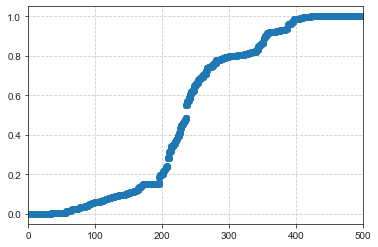

In [38]:
def find_ovi_loc_along_ray(sim, ray_id):
    l, temperature, density, metallicity, vlos, ocol, sicol = \
        load_sightline_scatter_data(model, ray_id)
    
    ocol_sum = np.cumsum(ocol)
    total_ocol = ocol_sum[-1]
    plt.scatter(l, ocol_sum / total_ocol)
    plt.xlim(0, 500)
    ovi_loc_along_ray = 0
    print(ocol_sum[-1])
    for i in range(len(ocol)):
        if ocol_sum[i] > 0.9*total_ocol:
            ovi_loc_along_ray = l[i] / 500 #fraction of 500 kpc
            break
    print(ovi_loc_along_ray)
    return ovi_loc_along_ray

test = find_ovi_loc_along_ray('P0', 0)

In [11]:
def plot_phase(xfield, yfield):
    
    trident.add_ion_fields(ds, ions = [ion])  
    
    sp1 = ds.sphere(gcenter, (15, 'kpc'))
    sp2 = ds.sphere(gcenter, (200, 'kpc'))
    sp = sp2 - sp1

    logx_list = xfield
    logy_list = yfield
    
    ion_name = ipd.return_ion_prefix(ion)
    mass_list = sp['%s_mass'%ion_name].in_units('Msun')


    xlims = (-5.2, -1.01)
    ylims = (3.8, 6.99)

    xedges = np.linspace(xlims[0], xlims[1], 100)
    yedges = np.linspace(ylims[0], ylims[1], 100)
    weights = mass_list
    normed = True
    #weights = None

    H, xedges, yedges = np.histogram2d(logx_list, logy_list, bins = (xedges, yedges), weights = weights, normed = normed)
    H = H.T
    X, Y = np.meshgrid(xedges, yedges)


    # definitions for the axes
    left, width = 0.12, 0.65
    bottom, height = 0.11, 0.65
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    fig = plt.figure(figsize=(7, 5.9))
    fs = 14
    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True, labelsize = fs)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False, labelsize = fs)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False, labelsize = fs)

    ax_scatter.set_xlim(xlims[0], xlims[1])
    ax_scatter.set_ylim(ylims[0], ylims[1])
    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())


    ax_scatter.set_xlabel('Log Number Density (cm$^{-3}$)', fontsize = fs)
    ax_scatter.set_ylabel('Log Temperature (K)', fontsize = fs)

   # palette = sns.color_palette("Blues")
#    cmap = cmListedColormap(palette)
    palette = pt.get_palette(ion)
    cmap = ListedColormap(palette)
    background = palette[0]

    ax_scatter.pcolormesh(X, Y, H, norm = LogNorm(), cmap = cmap)
    ax_scatter.set_facecolor(background)


    # add ion and model labels
    xtext = 0.8*(xlims[1] - xlims[0]) + xlims[0]
    ytext = 0.9*(ylims[1] - ylims[0]) + ylims[0]
    ax_scatter.text(xtext, ytext, ion, fontsize = fs+2, color = 'black')
    
    xtext = 0.08*(xlims[1] - xlims[0]) + xlims[0]
    if model == 'P0':
        ax_scatter.text(xtext, ytext, model, fontsize = fs+2, color = 'black')
    else:
        ax_scatter.text(xtext, ytext, 'P0 + CRs', fontsize = fs+2, color = 'black')


    
    ax_histx.hist(logx_list, bins=xedges, weights = weights, density = normed, color = palette[2])
    ax_histx.hist(logx_list, bins=xedges, weights = weights, density = normed, 
                  histtype = 'step', color = palette[-1])
    ax_histy.hist(logy_list, bins=yedges, weights = weights, density = normed, 
                  orientation = 'horizontal', color = palette[2])
    ax_histy.hist(logy_list, bins=yedges, weights = weights, density = normed, 
                  orientation = 'horizontal', histtype = 'step', color = palette[-1])


    plt.show()
    

<HDF5 dataset "O_p5_number_density": shape (800, 800), type "<f8">

In [19]:
#20, 10

np.log10(30) - np.log10(10)

0.4771212547196624

In [20]:
np.log10(10)

1.0